In [ ]:
# -*- coding: utf-8 -*-
"""FinalU-Net-Alternative.ipynb

Automatically generated by Colaboratory.

### Imports
"""

!pip install segmentation-models-pytorch
!pip install optuna

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import transforms
import os
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import optuna
import time
from google.colab import drive
import sys
import segmentation_models_pytorch as smp

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
if not os.path.exists('/content/kitti_dataset'):
    drive.mount('/content/drive')
    !unzip -q "/content/drive/My Drive/Colab Notebooks/data_semantics.zip" -d "/content/kitti_dataset"
else:
    print('Dataset already extracted.')

# Set the seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
class KITTIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if random.random() > 0.5:
          image = F.hflip(image)
          mask = F.hflip(mask)

        if self.transform:
            image, mask = self.transform(image, mask)  # Adjusted to pass both image and mask

        return image, mask

In [ ]:
from torchvision.transforms import functional as F

def transform(image, mask):
    # Resize images and masks to a fixed size
    image = F.resize(image, (512, 512))
    mask = F.resize(mask, (512, 512), interpolation=Image.NEAREST)

    # Convert to tensor
    image = F.to_tensor(image)
    mask = torch.from_numpy(np.array(mask)).long()  # CrossEntropyLoss expects long type tensor

    # Normalize the image with dataset mean and std
    normalize = transforms.Normalize(mean=mean, std=std)
    image = normalize(image)

    return image, mask

In [ ]:
### Initialize the Dataset
final_dataset = KITTIDataset(
    image_dir="/content/kitti_dataset/data_semantics/training/image_2",
    mask_dir="/content/kitti_dataset/data_semantics/training/semantic",
    transform=transform
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
### Training Loop Using Optuna for Hyperparameter Tuning
mean = [0.37910411, 0.39846688, 0.38367168]
std = [0.31077275, 0.31944112, 0.3287303]

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [2, 4, 8])
    epochs = 30
    weight_decay = 1e-5

    train_size = int(0.8 * len(final_dataset))
    val_size = len(final_dataset) - train_size
    train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = smp.Unet(encoder_name="resnet50", encoder_weights=None, in_channels=3, classes=34).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            if torch.isnan(loss) or torch.isinf(loss):
                print("Loss is NaN or Inf")
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for images, masks in validation_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            validation_loss += loss.item()

    validation_loss /= len(val_dataset)
    return validation_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, callbacks=[lambda study, trial: tqdm.write(f'Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}. Best is trial {study.best_trial.number} with value: {study.best_trial.value}.')])

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-04-09 02:11:24,073] A new study created in memory with name: no-name-bb993131-7cfb-4a36-9f0b-fc65d207996d
<ipython-input-8-2a5b91ea3407>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
100%|██████████| 30/30 [03:06<00:00,  6.23s/it]
[I 2024-04-09 02:14:33,008] Trial 0 finished with value: 0.1896056964993477 and parameters: {'lr': 0.00013485173152687744, 'batch_size': 4}. Best is trial 0 with value: 0.1896056964993477.


Trial 0 finished with value: 0.1896056964993477 and parameters: {'lr': 0.00013485173152687744, 'batch_size': 4}. Best is trial 0 with value: 0.1896056964993477.


100%|██████████| 30/30 [03:06<00:00,  6.21s/it]
[I 2024-04-09 02:17:41,237] Trial 1 finished with value: 0.3705096423625946 and parameters: {'lr': 0.004540693369825504, 'batch_size': 4}. Best is trial 0 with value: 0.1896056964993477.


Trial 1 finished with value: 0.3705096423625946 and parameters: {'lr': 0.004540693369825504, 'batch_size': 4}. Best is trial 0 with value: 0.1896056964993477.


100%|██████████| 30/30 [03:34<00:00,  7.14s/it]
[I 2024-04-09 02:21:17,352] Trial 2 finished with value: 0.40561520084738734 and parameters: {'lr': 0.00020255067283003164, 'batch_size': 2}. Best is trial 0 with value: 0.1896056964993477.


Trial 2 finished with value: 0.40561520084738734 and parameters: {'lr': 0.00020255067283003164, 'batch_size': 2}. Best is trial 0 with value: 0.1896056964993477.


100%|██████████| 30/30 [03:30<00:00,  7.01s/it]
[I 2024-04-09 02:24:49,543] Trial 3 finished with value: 0.46348899602890015 and parameters: {'lr': 0.00688638428786577, 'batch_size': 2}. Best is trial 0 with value: 0.1896056964993477.


Trial 3 finished with value: 0.46348899602890015 and parameters: {'lr': 0.00688638428786577, 'batch_size': 2}. Best is trial 0 with value: 0.1896056964993477.


100%|██████████| 30/30 [02:43<00:00,  5.46s/it]
[I 2024-04-09 02:27:35,199] Trial 4 finished with value: 0.1093310073018074 and parameters: {'lr': 0.005097385290100165, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


Trial 4 finished with value: 0.1093310073018074 and parameters: {'lr': 0.005097385290100165, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [03:30<00:00,  7.03s/it]
[I 2024-04-09 02:31:08,058] Trial 5 finished with value: 0.3118366673588753 and parameters: {'lr': 0.00010569693469866326, 'batch_size': 2}. Best is trial 4 with value: 0.1093310073018074.


Trial 5 finished with value: 0.3118366673588753 and parameters: {'lr': 0.00010569693469866326, 'batch_size': 2}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [02:45<00:00,  5.50s/it]
[I 2024-04-09 02:33:55,034] Trial 6 finished with value: 0.1686653435230255 and parameters: {'lr': 0.005703896797975917, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


Trial 6 finished with value: 0.1686653435230255 and parameters: {'lr': 0.005703896797975917, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [03:00<00:00,  6.03s/it]
[I 2024-04-09 02:36:57,723] Trial 7 finished with value: 0.16248378455638884 and parameters: {'lr': 0.00019159859737112562, 'batch_size': 4}. Best is trial 4 with value: 0.1093310073018074.


Trial 7 finished with value: 0.16248378455638884 and parameters: {'lr': 0.00019159859737112562, 'batch_size': 4}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [03:31<00:00,  7.05s/it]
[I 2024-04-09 02:40:31,063] Trial 8 finished with value: 0.3440047398209572 and parameters: {'lr': 0.0004618842867676124, 'batch_size': 2}. Best is trial 4 with value: 0.1093310073018074.


Trial 8 finished with value: 0.3440047398209572 and parameters: {'lr': 0.0004618842867676124, 'batch_size': 2}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [02:43<00:00,  5.46s/it]
[I 2024-04-09 02:43:16,608] Trial 9 finished with value: 0.11214054971933365 and parameters: {'lr': 0.00012312543387377076, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


Trial 9 finished with value: 0.11214054971933365 and parameters: {'lr': 0.00012312543387377076, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [02:43<00:00,  5.44s/it]
[I 2024-04-09 02:46:01,749] Trial 10 finished with value: 0.13348619192838668 and parameters: {'lr': 0.0021603255650747876, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


Trial 10 finished with value: 0.13348619192838668 and parameters: {'lr': 0.0021603255650747876, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [02:42<00:00,  5.43s/it]
[I 2024-04-09 02:48:46,393] Trial 11 finished with value: 0.14374757260084153 and parameters: {'lr': 0.0010100545811000156, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


Trial 11 finished with value: 0.14374757260084153 and parameters: {'lr': 0.0010100545811000156, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [02:43<00:00,  5.44s/it]
[I 2024-04-09 02:51:31,409] Trial 12 finished with value: 0.11956137269735337 and parameters: {'lr': 0.0017573392480680187, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


Trial 12 finished with value: 0.11956137269735337 and parameters: {'lr': 0.0017573392480680187, 'batch_size': 8}. Best is trial 4 with value: 0.1093310073018074.


100%|██████████| 30/30 [02:44<00:00,  5.48s/it]
[I 2024-04-09 02:54:17,598] Trial 13 finished with value: 0.08728900253772735 and parameters: {'lr': 0.0004224626672703283, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 13 finished with value: 0.08728900253772735 and parameters: {'lr': 0.0004224626672703283, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:44<00:00,  5.47s/it]
[I 2024-04-09 02:57:03,448] Trial 14 finished with value: 0.0920742243528366 and parameters: {'lr': 0.0005052304077098981, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 14 finished with value: 0.0920742243528366 and parameters: {'lr': 0.0005052304077098981, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:44<00:00,  5.47s/it]
[I 2024-04-09 02:59:49,481] Trial 15 finished with value: 0.09580649435520172 and parameters: {'lr': 0.00044285674981527507, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 15 finished with value: 0.09580649435520172 and parameters: {'lr': 0.00044285674981527507, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:43<00:00,  5.46s/it]
[I 2024-04-09 03:02:35,084] Trial 16 finished with value: 0.13739577829837799 and parameters: {'lr': 0.00046936458499463216, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 16 finished with value: 0.13739577829837799 and parameters: {'lr': 0.00046936458499463216, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:45<00:00,  5.50s/it]
[I 2024-04-09 03:05:21,938] Trial 17 finished with value: 0.1376892790198326 and parameters: {'lr': 0.0008297599981113511, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 17 finished with value: 0.1376892790198326 and parameters: {'lr': 0.0008297599981113511, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:44<00:00,  5.49s/it]
[I 2024-04-09 03:08:08,510] Trial 18 finished with value: 0.14401498734951018 and parameters: {'lr': 0.0003260179839709335, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 18 finished with value: 0.14401498734951018 and parameters: {'lr': 0.0003260179839709335, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [03:02<00:00,  6.07s/it]
[I 2024-04-09 03:11:12,443] Trial 19 finished with value: 0.18881186172366143 and parameters: {'lr': 0.0009238053687721014, 'batch_size': 4}. Best is trial 13 with value: 0.08728900253772735.


Trial 19 finished with value: 0.18881186172366143 and parameters: {'lr': 0.0009238053687721014, 'batch_size': 4}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:46<00:00,  5.56s/it]
[I 2024-04-09 03:14:01,095] Trial 20 finished with value: 0.09187985211610794 and parameters: {'lr': 0.0002909095831237367, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 20 finished with value: 0.09187985211610794 and parameters: {'lr': 0.0002909095831237367, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:47<00:00,  5.57s/it]
[I 2024-04-09 03:16:49,918] Trial 21 finished with value: 0.08907181471586227 and parameters: {'lr': 0.00027211506897491846, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 21 finished with value: 0.08907181471586227 and parameters: {'lr': 0.00027211506897491846, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:46<00:00,  5.56s/it]
[I 2024-04-09 03:19:38,374] Trial 22 finished with value: 0.08862208127975464 and parameters: {'lr': 0.0002680841470241316, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 22 finished with value: 0.08862208127975464 and parameters: {'lr': 0.0002680841470241316, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:44<00:00,  5.48s/it]
[I 2024-04-09 03:22:24,550] Trial 23 finished with value: 0.10856017917394638 and parameters: {'lr': 0.0001946619814289055, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 23 finished with value: 0.10856017917394638 and parameters: {'lr': 0.0001946619814289055, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:47<00:00,  5.58s/it]
[I 2024-04-09 03:25:13,859] Trial 24 finished with value: 0.09059997349977493 and parameters: {'lr': 0.0002856327491321389, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 24 finished with value: 0.09059997349977493 and parameters: {'lr': 0.0002856327491321389, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:46<00:00,  5.56s/it]
[I 2024-04-09 03:28:02,594] Trial 25 finished with value: 0.0923555389046669 and parameters: {'lr': 0.00026029173236535185, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 25 finished with value: 0.0923555389046669 and parameters: {'lr': 0.00026029173236535185, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:46<00:00,  5.54s/it]
[I 2024-04-09 03:30:50,549] Trial 26 finished with value: 0.20424873530864715 and parameters: {'lr': 0.0006645871098540943, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 26 finished with value: 0.20424873530864715 and parameters: {'lr': 0.0006645871098540943, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:48<00:00,  5.62s/it]
[I 2024-04-09 03:33:41,091] Trial 27 finished with value: 0.11137383282184601 and parameters: {'lr': 0.0014984040338926923, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


Trial 27 finished with value: 0.11137383282184601 and parameters: {'lr': 0.0014984040338926923, 'batch_size': 8}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [03:34<00:00,  7.16s/it]
[I 2024-04-09 03:37:17,771] Trial 28 finished with value: 0.33172234892845154 and parameters: {'lr': 0.00015612889057990093, 'batch_size': 2}. Best is trial 13 with value: 0.08728900253772735.


Trial 28 finished with value: 0.33172234892845154 and parameters: {'lr': 0.00015612889057990093, 'batch_size': 2}. Best is trial 13 with value: 0.08728900253772735.


100%|██████████| 30/30 [02:59<00:00,  5.99s/it]
[I 2024-04-09 03:40:19,303] Trial 29 finished with value: 0.1885783813893795 and parameters: {'lr': 0.0003521699437156587, 'batch_size': 4}. Best is trial 13 with value: 0.08728900253772735.


Trial 29 finished with value: 0.1885783813893795 and parameters: {'lr': 0.0003521699437156587, 'batch_size': 4}. Best is trial 13 with value: 0.08728900253772735.
Best trial:
  Value: 0.08728900253772735
  Params: 
    lr: 0.0004224626672703283
    batch_size: 8


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
vis.plot_param_importances(study)

NameError: name 'vis' is not defined

In [ ]:
# final training with best hyperparams
best_lr = 0.0004224626672703283
best_batch_size = 8
mean = [0.37910411, 0.39846688, 0.38367168]
std = [0.31077275, 0.31944112, 0.3287303]

# data loaders with best batch size
train_size = int(0.8 * len(final_dataset))
val_size = len(final_dataset) - train_size
train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# redeclare model with best hyperparams
model = smp.Unet(encoder_name="resnet50", encoder_weights=None, in_channels=3, classes=34).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

for epoch in tqdm(range(30)):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    print(f"epoch {epoch + 1}; loss = {loss.item()}")

torch.save(model.state_dict(), "unet_model.pth")
print("model saved")


  3%|▎         | 1/30 [00:05<02:45,  5.71s/it]

epoch 1; loss = 2.163626194000244


  7%|▋         | 2/30 [00:10<02:18,  4.96s/it]

epoch 2; loss = 1.5473177433013916


 10%|█         | 3/30 [00:14<02:07,  4.73s/it]

epoch 3; loss = 1.5357314348220825


 13%|█▎        | 4/30 [00:19<01:59,  4.61s/it]

epoch 4; loss = 1.208341121673584


 17%|█▋        | 5/30 [00:23<01:53,  4.55s/it]

epoch 5; loss = 1.0436732769012451


 20%|██        | 6/30 [00:27<01:48,  4.53s/it]

epoch 6; loss = 1.116396188735962


 23%|██▎       | 7/30 [00:32<01:43,  4.50s/it]

epoch 7; loss = 0.9095162153244019


 27%|██▋       | 8/30 [00:36<01:38,  4.48s/it]

epoch 8; loss = 0.8397936820983887


 30%|███       | 9/30 [00:41<01:34,  4.48s/it]

epoch 9; loss = 0.8089874982833862


 33%|███▎      | 10/30 [00:45<01:29,  4.46s/it]

epoch 10; loss = 0.7969503998756409


 37%|███▋      | 11/30 [00:50<01:24,  4.46s/it]

epoch 11; loss = 0.9109485745429993


 40%|████      | 12/30 [00:54<01:20,  4.46s/it]

epoch 12; loss = 0.845344066619873


 43%|████▎     | 13/30 [00:59<01:15,  4.44s/it]

epoch 13; loss = 0.6145107746124268


 47%|████▋     | 14/30 [01:03<01:11,  4.45s/it]

epoch 14; loss = 0.6475231051445007


 50%|█████     | 15/30 [01:07<01:06,  4.44s/it]

epoch 15; loss = 0.67369145154953


 53%|█████▎    | 16/30 [01:12<01:02,  4.43s/it]

epoch 16; loss = 0.6774762272834778


 57%|█████▋    | 17/30 [01:16<00:57,  4.44s/it]

epoch 17; loss = 0.9468762874603271


 60%|██████    | 18/30 [01:21<00:53,  4.44s/it]

epoch 18; loss = 0.6209179162979126


 63%|██████▎   | 19/30 [01:25<00:48,  4.44s/it]

epoch 19; loss = 0.636192798614502


 67%|██████▋   | 20/30 [01:30<00:44,  4.46s/it]

epoch 20; loss = 0.6101571917533875


 70%|███████   | 21/30 [01:34<00:40,  4.45s/it]

epoch 21; loss = 0.634636640548706


 73%|███████▎  | 22/30 [01:39<00:35,  4.45s/it]

epoch 22; loss = 0.8311035633087158


 77%|███████▋  | 23/30 [01:43<00:31,  4.45s/it]

epoch 23; loss = 0.4708169400691986


 80%|████████  | 24/30 [01:47<00:26,  4.44s/it]

epoch 24; loss = 0.6531053185462952


 83%|████████▎ | 25/30 [01:52<00:22,  4.45s/it]

epoch 25; loss = 0.7055349946022034


 87%|████████▋ | 26/30 [01:56<00:17,  4.45s/it]

epoch 26; loss = 0.5954704284667969


 90%|█████████ | 27/30 [02:01<00:13,  4.45s/it]

epoch 27; loss = 0.8057603240013123


 93%|█████████▎| 28/30 [02:05<00:08,  4.45s/it]

epoch 28; loss = 0.5612331032752991


 97%|█████████▋| 29/30 [02:10<00:04,  4.44s/it]

epoch 29; loss = 0.6374221444129944


100%|██████████| 30/30 [02:14<00:00,  4.49s/it]

epoch 30; loss = 0.5651143789291382
model saved


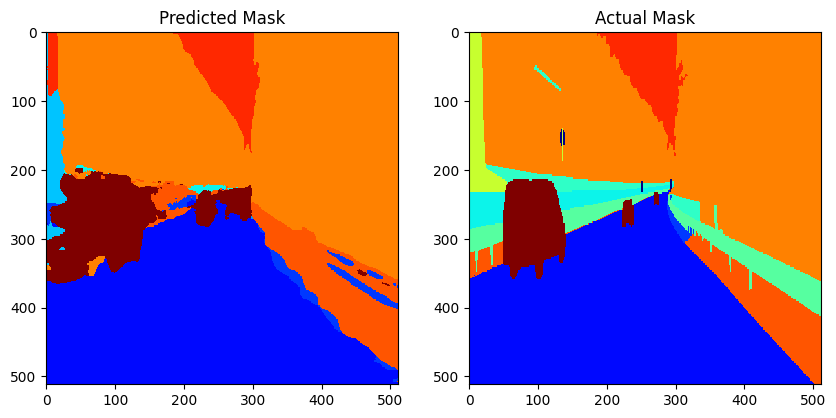

Image Name: 000190_10.png


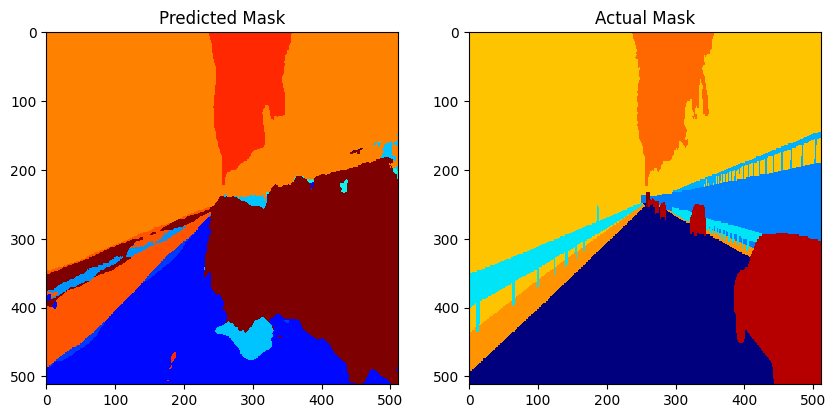

Image Name: 000194_10.png


In [ ]:
model.eval()
visualize_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)  # Set shuffle=False to maintain order
target_images = [f'{str(i).zfill(6)}_10.png' for i in range(190, 201)]  # List of target image names

with torch.no_grad():
    for i, (images, masks) in enumerate(visualize_loader):
        image_name = val_dataset.dataset.images[val_dataset.indices[i]]
        if image_name not in target_images:
            continue  # Skip images that are not in the target range
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        predicted_masks = np.flip(outputs.argmax(dim=1).cpu().numpy(), axis=2)
        actual_masks = np.flip(masks.cpu().numpy(), axis=2)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(predicted_masks[0], cmap='jet', interpolation='nearest')
        plt.title('Predicted Mask')
        plt.subplot(1, 2, 2)
        plt.imshow(actual_masks[0], cmap='jet', interpolation='nearest')
        plt.title('Actual Mask')
        plt.show()

        print(f'Image Name: {image_name}')




In [ ]:
# performance metrics

def measure_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predicted_masks = outputs.argmax(dim=1)
            correct += (predicted_masks == masks).sum().item()
            total += torch.numel(predicted_masks)
    return correct / total

def measure_performance(model, dataloader, device):
  model.eval()
  start_time = time.time()
  with torch.no_grad():
    for images, masks in dataloader:
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
  end_time = time.time()
  inference_time = end_time - start_time
  return inference_time

accuracy = measure_accuracy(model, validation_loader, device)
inference_time = measure_performance(model, validation_loader, device)
model_size = os.path.getsize('unet_model.pth') / (1024 * 1024)

print(f"accuracy: {accuracy * 100:.2f}%")
print(f"inference time: {inference_time * 1000:.2f} ms")
print(f"model size: {model_size:.2f} MB")

accuracy: 82.94%
inference time: 893.31 ms
model size: 124.41 MB


In [ ]:
# classification metrics
model.eval()
model.to(device)

predictions = []
targets = []

with torch.no_grad():
    for images, masks in validation_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        targets.extend(masks.cpu().numpy())

labels = [
    {'name': 'unlabeled', 'id': 0, 'category': 'void', 'catId': 0},
    {'name': 'ego vehicle', 'id': 1, 'category': 'void', 'catId': 0},
    {'name': 'rectification border', 'id': 2, 'category': 'void', 'catId': 0},
    {'name': 'out of roi', 'id': 3, 'category': 'void', 'catId': 0},
    {'name': 'static', 'id': 4, 'category': 'void', 'catId': 0},
    {'name': 'dynamic', 'id': 5, 'category': 'void', 'catId': 0},
    {'name': 'ground', 'id': 6, 'category': 'void', 'catId': 0},
    {'name': 'road', 'id': 7, 'category': 'flat', 'catId': 1},
    {'name': 'sidewalk', 'id': 8, 'category': 'flat', 'catId': 1},
    {'name': 'parking', 'id': 9, 'category': 'flat', 'catId': 1},
    {'name': 'rail track', 'id': 10, 'category': 'flat', 'catId': 1},
    {'name': 'building', 'id': 11, 'category': 'construction', 'catId': 2},
    {'name': 'wall', 'id': 12, 'category': 'construction', 'catId': 2},
    {'name': 'fence', 'id': 13, 'category': 'construction', 'catId': 2},
    {'name': 'guard rail', 'id': 14, 'category': 'construction', 'catId': 2},
    {'name': 'bridge', 'id': 15, 'category': 'construction', 'catId': 2},
    {'name': 'tunnel', 'id': 16, 'category': 'construction', 'catId': 2},
    {'name': 'pole', 'id': 17, 'category': 'object', 'catId': 3},
    {'name': 'polegroup', 'id': 18, 'category': 'object', 'catId': 3},
    {'name': 'traffic light', 'id': 19, 'category': 'object', 'catId': 3},
    {'name': 'traffic sign', 'id': 20, 'category': 'object', 'catId': 3},
    {'name': 'vegetation', 'id': 21, 'category': 'nature', 'catId': 4},
    {'name': 'terrain', 'id': 22, 'category': 'nature', 'catId': 4},
    {'name': 'sky', 'id': 23, 'category': 'sky', 'catId': 5},
    {'name': 'person', 'id': 24, 'category': 'human', 'catId': 6},
    {'name': 'rider', 'id': 25, 'category': 'human', 'catId': 6},
    {'name': 'car', 'id': 26, 'category': 'vehicle', 'catId': 7},
    {'name': 'truck', 'id': 27, 'category': 'vehicle', 'catId': 7},
    {'name': 'bus', 'id': 28, 'category': 'vehicle', 'catId': 7},
    {'name': 'caravan', 'id': 29, 'category': 'vehicle', 'catId': 7},
    {'name': 'trailer', 'id': 30, 'category': 'vehicle', 'catId': 7},
    {'name': 'train', 'id': 31, 'category': 'vehicle', 'catId': 7},
    {'name': 'motorcycle', 'id': 32, 'category': 'vehicle', 'catId': 7},
    {'name': 'bicycle', 'id': 33, 'category': 'vehicle', 'catId': 7},
]
class_names = [label['name'] for label in labels]

In [ ]:
# Calculate Metrics IoU, mIoU, Precision, Recall, and FI-Score
from sklearn.metrics import confusion_matrix

def calculate_metrics(predictions, targets, num_classes):
    num_classes = len(labels)
    class_names = [label['name'] for label in labels]
    # Flatten predictions and targets
    predictions_flat = np.array(predictions).flatten()
    targets_flat = np.array(targets).flatten()

    # Initialize variables to store metrics
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)
    true_positives = np.zeros(num_classes)
    false_positives = np.zeros(num_classes)
    false_negatives = np.zeros(num_classes)

    # Calculate metrics for each class
    for class_id in range(num_classes):
        class_predictions = (predictions_flat == class_id)
        class_targets = (targets_flat == class_id)

        intersection[class_id] = np.logical_and(class_predictions, class_targets).sum()
        union[class_id] = np.logical_or(class_predictions, class_targets).sum()
        true_positives[class_id] = intersection[class_id]
        false_positives[class_id] = np.logical_and(class_predictions, ~class_targets).sum()
        false_negatives[class_id] = np.logical_and(~class_predictions, class_targets).sum()

    # Exclude classes with NaN values from computation
    valid_classes = np.where(~np.isnan(union))[0]
    intersection = intersection[valid_classes]
    union = union[valid_classes]
    true_positives = true_positives[valid_classes]
    false_positives = false_positives[valid_classes]
    false_negatives = false_negatives[valid_classes]

    # Calculate IoU, Precision, Recall, and F1-Score
    iou = np.divide(intersection, union, out=np.zeros_like(intersection), where=union!=0)
    precision = np.divide(true_positives, (true_positives + false_positives), out=np.zeros_like(true_positives), where=(true_positives + false_positives)!=0)
    recall = np.divide(true_positives, (true_positives + false_negatives), out=np.zeros_like(true_positives), where=(true_positives + false_negatives)!=0)
    # handling of division by zero
    valid_precision_recall_mask = (precision + recall) > 0
    f1_score = np.zeros_like(precision)
    f1_score[valid_precision_recall_mask] = 2 * (precision[valid_precision_recall_mask] * recall[valid_precision_recall_mask]) / (precision[valid_precision_recall_mask] + recall[valid_precision_recall_mask])

    metrics_with_names = {}
    for i, name in enumerate(class_names):
        metrics_with_names[name] = {
            'IoU': iou[i],
            'Precision': precision[i],
            'Recall': recall[i],
            'F1-Score': f1_score[i]
        }

    # Calculate mIoU
    valid_iou = [metrics_with_names[name]['IoU'] for name in class_names]
    mIoU = np.mean(valid_iou)

    return mIoU, metrics_with_names

mIoU, metrics_with_names = calculate_metrics(predictions, targets, labels)

# Initialize sums of metrics
sum_precision = 0
sum_recall = 0
sum_f1_score = 0
count = 0

# Iterate over each class to sum up metrics
for class_name, metrics in metrics_with_names.items():
    sum_precision += metrics['Precision']
    sum_recall += metrics['Recall']
    sum_f1_score += metrics['F1-Score']
    count += 1

# Calculate averages
average_precision = sum_precision / count
average_recall = sum_recall / count
average_f1_score = sum_f1_score / count

# Print mIoU and Average Metrics
print(f"mIoU: {mIoU:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1_score:.4f}")
for class_name, scores in metrics_with_names.items():
    print(f"Class: {class_name}, Scores: {scores}")

mIoU: 0.1535
Average Precision: 0.2105
Average Recall: 0.1857
Average F1-Score: 0.1831
Class: unlabeled, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: ego vehicle, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: rectification border, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: out of roi, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: static, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: dynamic, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: ground, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: road, Scores: {'IoU': 0.8164158018331945, 'Precision': 0.8982893544738582, 'Recall': 0.899572604093502, 'F1-Score': 0.8989305213148192}
Class: sidewalk, Scores: {'IoU': 0.3179257969815117, 'Precision': 0.488605402086497, 'Recall': 0.4764748336050894, 'F1-Score': 0.482463880302